[*********************100%***********************]  1 of 1 completed


Text Metrics:
duration: (31, 167, 75.42857142857143, 58.0, 53.275563950893236)
total_return: 357.06943843882186
buy_and_hold_performance: 43.8358608235763
volatility: 2.8804527059824365
maximum_drawdown: 0.06744412727403581
win_loss_ratio: 7.0


/Users/jmordetsky/Library/Python/3.8/lib/python/site-packages/seaborn/algorithms.py:98: RuntimeWarning:

Mean of empty slice

/Users/jmordetsky/Library/Python/3.8/lib/python/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning:

All-NaN slice encountered



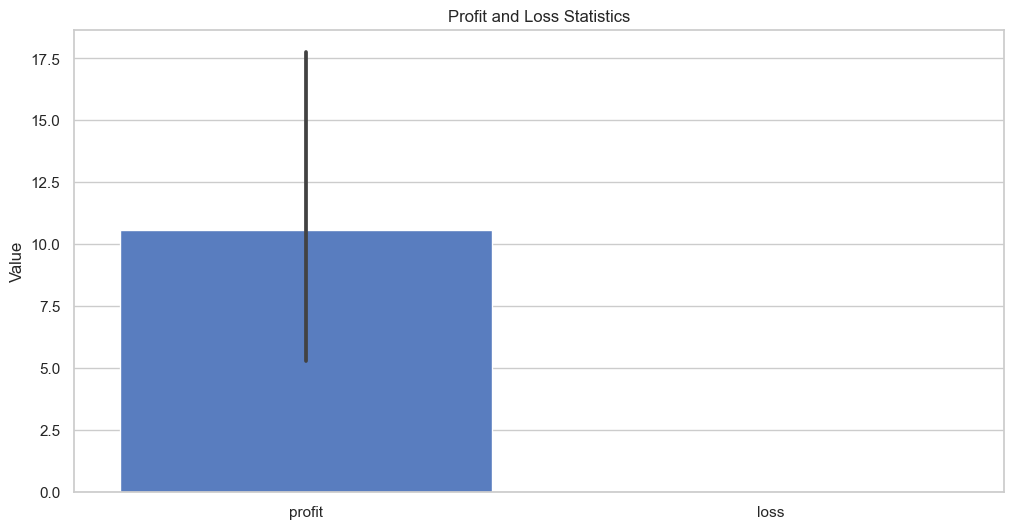

,Unnamed: 0,Date,Product,Side,Action,Profit_Percent,Profit_Actual,Fee,Value,Price,Shares,Cost
0,0,2021-11-30,XLE,long,enter,0.000000,0.000000,12.500000,4925.869000,55.135900,90.0,4974.731014
1,0,2022-05-16,XLE,long,exit,51.877640,2555.447021,18.841298,7530.447021,83.739104,0.0,0.000000
2,0,2022-05-16,DUG,long,enter,0.000000,0.000000,18.826118,7418.554788,18.745599,400.0,7517.065902
3,0,2022-06-23,DUG,long,exit,25.484922,1887.397685,23.522901,9380.192470,23.522901,0.0,0.000000
4,0,2022-06-23,XLE,long,enter,0.000000,0.000000,23.450481,9240.726903,71.366604,131.0,9372.475566
5,0,2022-08-23,XLE,long,exit,16.289264,1495.707592,27.179781,10828.999100,82.991698,0.0,0.000000
6,0,2022-08-23,DUG,long,enter,0.000000,0.000000,27.072498,10667.955805,15.947900,677.0,10823.800772
7,0,2022-09-23,DUG,long,exit,26.979096,2878.585734,34.273970,13653.439839,20.250499,0.0,0.000000
8,0,2022-09-23,XLE,long,enter,0.000000,0.000000,34.133600,13450.555833,71.184803,191.0,13630.431047
9,0,2022-11-01,XLE,long,exit,28.930191,3889.610452,43.824331,17474.783091,91.778703,0.0,0.000000


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from machine_learning_finance import analyze_trades, calc_probabilties_without_lookahead,plot_backtest_analysis
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
windows = [300, 600, 900, 1500]

# todo because the inverse strategy is long and long inverse it doesn't render correctl
# we should hack to render as short or render a second time series
file = "../backtests/backtest_inverse_XLE_365_h0.9_l0.1.csv"
symbol = "XLE"
period = 365 * 2
pd.options.display.max_rows = None


def plot_win_loss(file, symbol, period):
    ledger = pd.read_csv(file)
    metrics = analyze_trades(ledger, symbol, period)

    # Set the style for the plots
    sns.set(style='whitegrid')

    # Display metrics as text
    print("Text Metrics:")
    for key, value in metrics.items():
        if key not in ['profit_stats', 'loss_stats']:
            print(f"{key}: {value}")

    # Create a bar plot for profit and loss stats
    profit_stats, loss_stats = metrics['profit_stats'], metrics['loss_stats']
    profit_loss_df = pd.DataFrame([profit_stats, loss_stats], columns=['min', 'max', 'mean', 'median', 'std'], index=['profit', 'loss'])

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=profit_loss_df.transpose(), palette='muted')
    ax.set_title('Profit and Loss Statistics')
    ax.set_ylabel('Value')

    # Show the plot
    plt.show()

def analyze_and_graph(file, symbol, period):
    ledger = pd.read_csv(file)
    ticker_obj = yf.download(tickers=symbol)
    df = pd.DataFrame(ticker_obj)
    hist_df = df.head(len(df)-period)
    hist_df = hist_df.tail(period*4)
    df = df.tail(period)
    df = calc_probabilties_without_lookahead(df, hist_df)
    plot_backtest_analysis(df, ledger)

    return ledger, df


ledger, df = analyze_and_graph(file, "XLE", 365*4)    
plot_win_loss(file, "XLE", 365*4)
ledger